# Physics-Informed Neural Networks (PINNs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solving partial differential equations (PDEs) in the Neuromancer library.

### References

[1] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[2] This tutorial is based on the [Pytorch PINNs tutorial](https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/blob/main/PINNs/4_DiffusionEquation.ipynb) made by [Juan Diego Toscano](https://github.com/jdtoscano94). 


## Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install pyDOE

## Imports

In [1]:
# torch and numpy imports
import torch
import torch.nn as nn                    
import numpy as np
# plotting imports
import matplotlib.pyplot as plt

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem Setup

original source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

**Diffusion equation**

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

**Initial Condition:**

$$y(x,0)=sin(\pi x)$$

**Boundary Conditions:**

$$y(-1,t)=0$$
$$y(1,t)=0$$

**Exact solution:**

$$y(x,t)=e^{-t}sin(\pi x)$$

## Generate data of the exact solution

In [3]:
# exact solution y(x,t)
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

# define range of the space and time variables:
x_min=-1
x_max=1
t_min=0
t_max=1

# define number of spatial and temporal points
total_points_x=200
total_points_t=100

# generate samples of x, t
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)

# Create the mesh of x, t
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))

# Evaluate exact solution y(x,t) on the mesh
y_real=f_real(X,T)

# data shapes
print(x.shape, t.shape)
print(X.shape, T.shape, y_real.shape)

torch.Size([200, 1]) torch.Size([100, 1])
torch.Size([200, 100]) torch.Size([200, 100]) torch.Size([200, 100])


C:\Users\drgo694\OneDrive - PNNL\Documents\anaconda3\envs\neuromancer\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# min and max values of the PDE solution
ymin = y_real.min()
ymax = y_real.max()
print(ymin, ymax)

tensor(-1.0000) tensor(1.0000)


### Plot the exact solution

In [5]:
def plot3D(X, T, y):
    #     2D
  fig = plt.figure()
  ax1 = fig.add_subplot(121)
  cm = ax1.contourf(T.numpy(), X.numpy(), y.numpy(), 20,cmap="viridis")
  fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
  ax1.set_title('y(x,t)')
  ax1.set_xlabel('t')
  ax1.set_ylabel('x')
  ax1.set_aspect('equal')
    #     3D
  ax2 = fig.add_subplot(122, projection='3d')
  ax2.plot_surface(T.numpy(), X.numpy(), y.numpy(),cmap="viridis")
  ax2.set_xlabel('t')
  ax2.set_ylabel('x')
  ax2.set_zlabel('y(x,t)')
  fig.tight_layout()

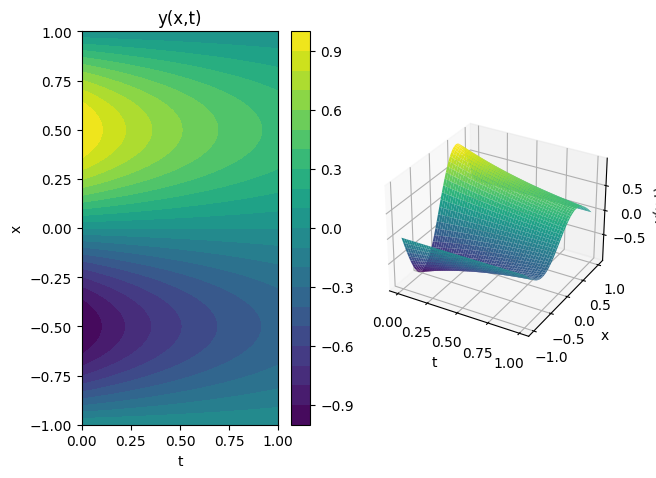

In [6]:
plot3D(X,T,y_real) 

### Test data: exact PDE solution

In [7]:
# Transform the mesh into a 2-column vector
X_test= X.transpose(1,0).flatten()[:,None].float() # the input dataset of x
T_test= T.transpose(1,0).flatten()[:,None].float() # the input dataset of t
Y_test= y_real.transpose(1,0).flatten()[:,None].float() # the real solution over (x,t) 
print(X_test.shape,T_test.shape,Y_test.shape)

torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([20000, 1])


##  Construct training datasets

We construct training and development datasets containing[ collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatio-temporal domain (x,t) evaluated at the sampled spatio-temporal mesh (x,t), and samples of the [initial conditions (IC)](https://en.wikipedia.org/wiki/Initial_condition), and [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/dev}} = [\texttt{CP}^i, \texttt{IC}^j, \texttt{BC}^j]$, $i = 1,...,N_f$, $j = 1,...,N_u$  
Where $N_f$ defines number of collocation points, and $N_u$ number of initial and boundary condition samples.

### Samples of Initial Condition (IC)

In [8]:
#   Left Edge: y(x,0)=sin(x) -> xmin =< x =< xmax; t=0
left_X = X[:, [0]]
left_T = T[:, [0]]
left_Y = torch.sin(np.pi * left_X[:, 0]).unsqueeze(1)
print(left_X.shape, left_T.shape, left_Y.shape)

torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


### Samples of Boundary Conditions (BC)

In [9]:
#   Bottom Edge: x=min; tmin=<t=<max
bottom_X = X[[0], :].T
bottom_T = T[[0], :].T
bottom_Y = torch.zeros(bottom_X.shape[0], 1)
print(bottom_X.shape, bottom_T.shape, bottom_Y.shape)
#   Top Edge: x=max; 0=<t=<1
top_X = X[[-1], :].T
top_T = T[[-1], :].T
top_Y = torch.zeros(top_X.shape[0], 1)
print(top_X.shape, top_T.shape, top_Y.shape)

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])


### Number of training samples for IC and BC

In [10]:
# Get all the initial and boundary condition data
X_train = torch.vstack([left_X, bottom_X, top_X])
T_train = torch.vstack([left_T, bottom_T, top_T])
Y_train = torch.vstack([left_Y, bottom_Y, top_Y])
print(X_train.shape, T_train.shape, Y_train.shape)

# Choose (Nu) Number of training points for initial and boundary conditions
Nu = 200

# Randomly sample Nu points of our available initial and boundary condition data:
idx = np.sort(np.random.choice(X_train.shape[0], Nu, replace=False))
X_train_Nu = X_train[idx, :].float()  # Training Points  of x at (IC+BC)
T_train_Nu = T_train[idx, :].float()  # Training Points  of t at (IC+BC)
Y_train_Nu = Y_train[idx, :].float()  # Training Points  of y at (IC+BC)
print(X_train_Nu.shape, T_train_Nu.shape, Y_train_Nu.shape)

torch.Size([400, 1]) torch.Size([400, 1]) torch.Size([400, 1])
torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


### Samples of Collocation Points (CP)

In [11]:
# x Domain bounds
x_lb = X_test[0]  # first value
x_ub = X_test[-1]  # last value
print(x_lb, x_ub)

# t Domain bounds
t_lb = T_test[0]  # first value
t_ub = T_test[-1]  # last value
print(t_lb, t_ub)

#  Choose (Nf) Collocation Points to Evaluate the PDE on
Nf = 1000  # Nf: Number of collocation points (Evaluate PDE)

# generate collocation points (CP)
X_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(x_lb), float(x_ub))
T_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(t_lb), float(t_ub))
print(X_train_CP.shape, T_train_CP.shape)

# add IC+BC to the collocation points
X_train_Nf = torch.vstack((X_train_CP, X_train_Nu)).float()  # Collocation Points of x (CP)
T_train_Nf = torch.vstack((T_train_CP, T_train_Nu)).float()  # Collocation Points of t (CP)
print(X_train_Nf.shape, T_train_Nf.shape)

tensor([-1.]) tensor([1.])
tensor([0.]) tensor([1.])
torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([1200, 1]) torch.Size([1200, 1])


In [12]:
print("Original shapes for X, T, and Y:",X.shape,T.shape,y_real.shape)
print("Initial and Boundary condition shapes for X:",left_X.shape,bottom_X.shape,top_X.shape)
print("Initial and Boundary condition shapes for T:",left_T.shape,bottom_T.shape,top_T.shape)
print("Available training data of IC and BC (X,T,Y):",X_train.shape,T_train.shape,Y_train.shape)
print("Selected training data of IC and BC (X,T,Y):",X_train_Nu.shape,T_train_Nu.shape,Y_train_Nu.shape)
print("Final training data of CP (X,T):",X_train_Nf.shape, T_train_Nf.shape)
print("Final test data (X,T,Y):",X_test.shape, T_test.shape, Y_test.shape)

Original shapes for X, T, and Y: torch.Size([200, 100]) torch.Size([200, 100]) torch.Size([200, 100])
Initial and Boundary condition shapes for X: torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([100, 1])
Initial and Boundary condition shapes for T: torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([100, 1])
Available training data of IC and BC (X,T,Y): torch.Size([400, 1]) torch.Size([400, 1]) torch.Size([400, 1])
Selected training data of IC and BC (X,T,Y): torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])
Final training data of CP (X,T): torch.Size([1200, 1]) torch.Size([1200, 1])
Final test data (X,T,Y): torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([20000, 1])


### Plot collocation points

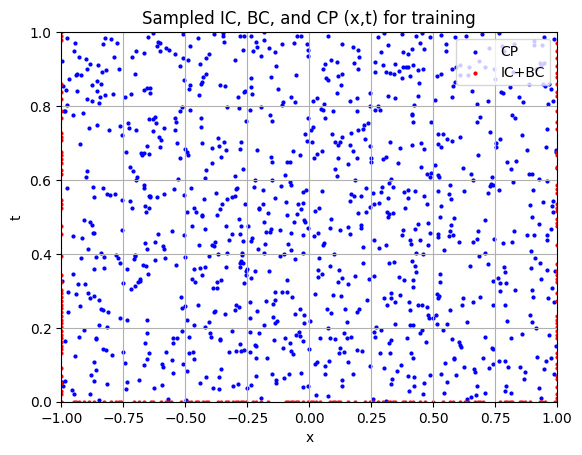

In [13]:
# visualize collocation points for 2D input space (x, t)
plt.figure()
plt.scatter(X_train_CP.detach().numpy(), T_train_CP.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.scatter(X_train_Nu.detach().numpy(), T_train_Nu.detach().numpy(),
            s=4., c='red', marker='o', label='IC+BC')
plt.title('Sampled IC, BC, and CP (x,t) for training')
plt.xlim(x_lb, x_ub)
plt.ylim(t_lb, t_ub)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

### Create Neuromancer datasets

In [14]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nf.requires_grad=True
T_train_Nf.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nf, 't':T_train_Nf}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 't':T_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train_Nf.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## PINN Architecture in Neuromancer

### Neural Network Architecture

We will use a neural network to approximate the PDE solution:
$$\hat{y} = NN_{\theta}(x,t)$$  

In [15]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# neural net to solve the PDE problem bounded in the PDE domain 
net = blocks.MLP(insize=2, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 't'], ['y_hat'], name='net')

In [16]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 't']
symbolic outputs of the pde_net: ['y_hat']


In [17]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['y_hat'].shape

torch.Size([1200, 1])

###  Define Physics-informed terms of the PINN

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,t) \approx y(x,t)$. 
Thus we define the physics-informed layers as $f_{\texttt{PINN}}$:

$$f_{\texttt{PINN}}(t,x)=\left(\frac{\partial NN_{\theta}}{\partial t} -\frac{\partial^2 NN_{\theta}}{\partial x^2}
\right)+e^{-t}(sin(\pi x)-\pi^2 sin(\pi x)) $$

We can obtain the derivatives of the neural net $\frac{\partial NN_{\theta}}{\partial t},\frac{\partial^2 NN_{\theta}}{\partial x^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). 

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library. 

In [18]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
y_hat = variable('y_hat')  # PDE solution generated as the output of a neural net (pde_net)
t = variable('t')  # temporal domain
x = variable('x')  # spatial domain

In [19]:
# get the symbolic derivatives
dy_dt = y_hat.grad(t)
dy_dx = y_hat.grad(x)
d2y_d2x = dy_dx.grad(x)
# get the PINN form
f_pinn = dy_dt - d2y_d2x + torch.exp(-t)* (torch.sin(torch.pi * x) - torch.pi ** 2 * torch.sin(torch.pi * x))

In [20]:
# check the shapes of the forward pass of the symbolic PINN terms
print(dy_dt({**net_out, **train_data.datadict}).shape)
print(dy_dx({**net_out, **train_data.datadict}).shape)
print(d2y_d2x({**net_out, **train_data.datadict}).shape)
print(f_pinn({**net_out, **train_data.datadict}).shape)

torch.Size([1200, 1])
torch.Size([1200, 1])
torch.Size([1200, 1])
torch.Size([1200, 1])


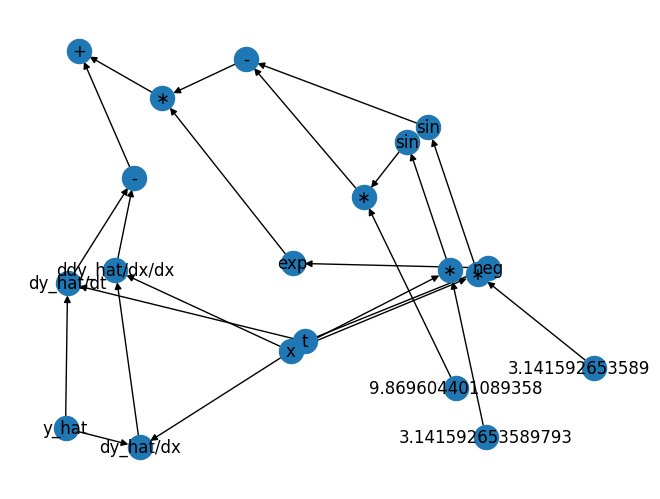

In [21]:
# computational graph of the PINN neural network
f_pinn.show()

### PINNs' Loss function terms

**PDE Collocation Points Loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over given number ($N_f$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{f}=\frac{1}{N_f}\sum^{N_f}_{i=1}|f_{\texttt{PINN}}(t_f^i,x_f^i)|^2$$


If $f_{\texttt{PINN}}\rightarrow 0$ then our PINN will be respecting the physical law.

**PDE Initial and Boundary Conditions Loss:**

We select $N_u$ points from our BC and IC and used them in the following supervised learning loss function:

$$\ell_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN_{\theta}(t_{u}^i,x_u^i)|^2$$

**Bound the PINN output in the PDE solution domain:**  
We expect the outputs of the neural net to be bounded in the PDE solution domain $NN_{\theta}(x,t) \in [-1.0, 1.0]$, thus we impose the following inequality constraints via additional penalties:

$$\ell_{y}=\frac{1}{N_f}\sum^{N_f}_{i=1} \Big(|\texttt{RELU}(NN_{\theta}(t_{f}^i,x_f^i) - y_{max})|^2 + |\texttt{RELU}(-NN_{\theta}(t_{f}^i,x_f^i) + y_{min})|^2 \Big)$$


#### Total Loss:
The total loss is just a sum of PDE residuals over CP and supervised learning residuals over IC and BC.
$$\ell_{\text{PINN}}=\ell_{f}+\ell_{u} +\ell_{y}$$

In [22]:
# scaling factor for better convergence
scaling = 100.

# PDE CP loss
ell_f = scaling*(f_pinn == 0.)^2

# PDE IC and BC loss
ell_u = scaling*(y_hat[-Nu:] == Y_train_Nu)^2  # remember we stacked CP with IC and BC

# output constraints to bound the PINN solution in the PDE output domain [-1.0, 1.0]
con_1 = scaling*(y_hat <= ymax)^2
con_2 = scaling*(y_hat >= ymin)^2

##  Train the PINN to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}(t,x)$ approximating the solution to the PDE equation $y(t,x)$ using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP, IP, and BC.

### Define the optimization problem in Neuromancer

In [23]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_f, ell_u], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

### Construct Trainer and solve the problem  

In [24]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
epochs = 5000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
)

In [25]:
# Train PINN
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 1760.5653076171875
epoch: 200  train_loss: 9.442874908447266
epoch: 400  train_loss: 1.7678855657577515
epoch: 600  train_loss: 0.9978040456771851
epoch: 800  train_loss: 0.5323354005813599
epoch: 1000  train_loss: 0.31986990571022034
epoch: 1200  train_loss: 0.21872836351394653
epoch: 1400  train_loss: 0.15970805287361145
epoch: 1600  train_loss: 0.12045641988515854
epoch: 1800  train_loss: 0.09165304899215698
epoch: 2000  train_loss: 0.06972993165254593
epoch: 2200  train_loss: 0.0527302548289299
epoch: 2400  train_loss: 0.049672313034534454
epoch: 2600  train_loss: 0.030742663890123367
epoch: 2800  train_loss: 0.024085916578769684
epoch: 3000  train_loss: 0.02318488247692585
epoch: 3200  train_loss: 0.016270525753498077
epoch: 3400  train_loss: 0.03823939338326454
epoch: 3600  train_loss: 0.011628623120486736
epoch: 3800  train_loss: 0.010083618573844433
epoch: 4000  train_loss: 0.009044604375958443
epoch: 4200  train_loss: 0.008052429184317589
epoch: 4400  tra

<All keys matched successfully>

### Plots

In [32]:
# evaluate trained PINN on test data
PINN = problem.nodes[0]
y1= PINN(test_data.datadict)['y_hat']

# arrange data for plotting
arr_y1 = y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

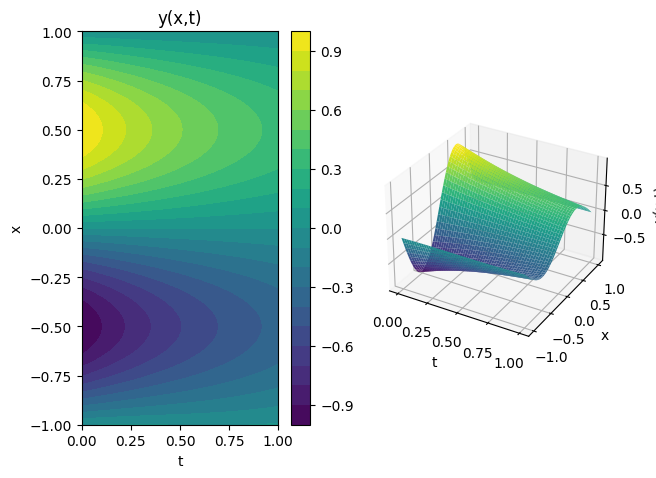

In [33]:
# plot PINN solution
plot3D(arr_x1,arr_T1,arr_y1)

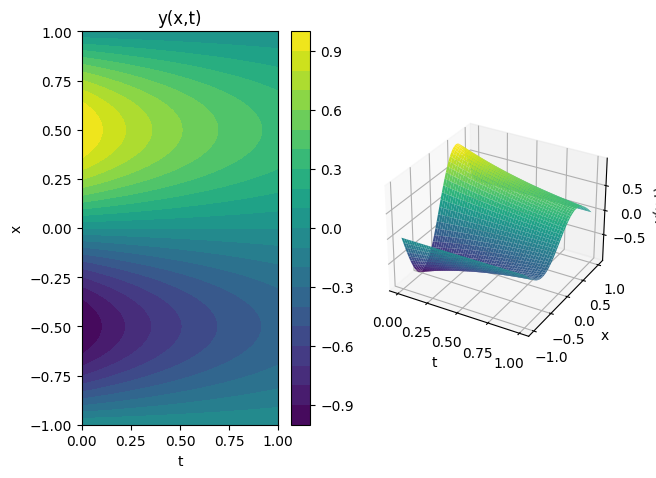

In [34]:
# plot exact PDE solution
plot3D(X,T,y_real)

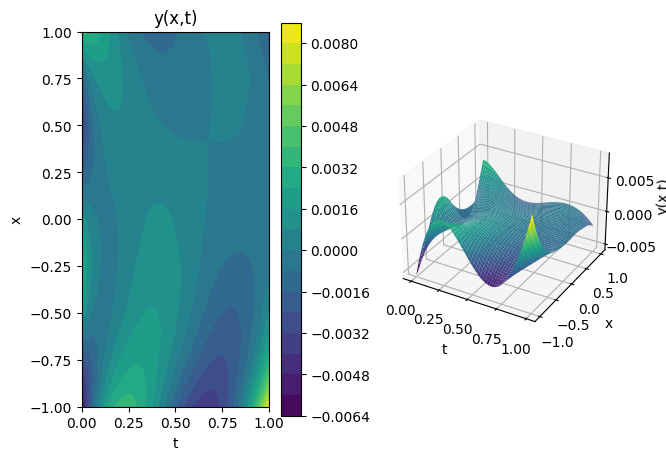

In [35]:
# plot residuals PINN - exact PDE
plot3D(X, T, arr_y1-y_real)